**Эту тетрадку можно запускать начиная с 2-ого пункта!**

In [1]:
# ! pip install python-Levenshtein

In [2]:
# from utils.make_sample import make_sample
# import Levenshtein
import pandas as pd
import numpy as np
%config IPCompleter.use_jedi = False

In [6]:
path_to_file = "./data/redir"
data = make_sample(path_to_file)

In [15]:
data.shape

(3003, 4)

In [16]:
data.head()

,query,category_id,category_name,is_redirect
0,dior хайлайтер,3327621,Хайлайтеры,1
1,dior хайлатер,3327621,Хайлайтеры,1
2,diorskin mineral nude luminizer,3327621,Хайлайтеры,1
3,хайдайтер dior,3327621,Хайлайтеры,1
4,хайлайтер dior,3327621,Хайлайтеры,1


In [23]:
data['category_name'].iloc[-2]

'для глаз'

## Подготовка train/test

In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
    data,
    stratify=data['is_redirect'],
    random_state=0,
    shuffle=True,
    test_size=0.2
)

In [28]:
train.shape

(2402, 4)

In [29]:
test.shape

(601, 4)

In [30]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [35]:
train.head()

,query,category_id,category_name,is_redirect
2733,revolution makeup ultra,873895,для глаз,0
1715,secret skin mimi hydrogel eye patch,873917,уход для губ,0
947,Huksamsoo,3329198,Huksamsoo,1
1410,зилински,3327781,Zielinski & Rozen,1
2957,туалетная вода bvlgari omnia coral,873894,мужские ароматы,0


## Бейзлайн

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config IPCompleter.use_jedi = False
%matplotlib inline

train = pd.read_csv("train.csv")
train.head(2)

,query,category_id,category_name,is_redirect
0,revolution makeup ultra,873895,для глаз,0
1,secret skin mimi hydrogel eye patch,873917,уход для губ,0


In [2]:
from pipeline.training import SCORING, STRONG_CV
from pipeline.training import save_pipeline, load_pipeline, fit_pipeline
from pipeline.training import make_tfidf_baseline, cross_validate_pipeline
from utils.learning_tools import plot_learning_curve

In [3]:
N_JOBS = 1
N_JOBS_CV = 4
pipeline = make_tfidf_baseline(N_JOBS)

result = cross_validate_pipeline(
    pipeline,
    train,
    train['is_redirect'],
    cv=STRONG_CV,
    scoring=SCORING,
    n_jobs=N_JOBS_CV,
    verbose=1,
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished


In [5]:
result

{'fit_time': array([0.26448202, 0.30593371, 0.3443408 , 0.31953216, 0.26740861,
        0.24873376, 0.27444386, 0.25198507, 0.22937965, 0.24636555,
        0.25215816, 0.26847124, 0.24492407, 0.22564793, 0.26036167,
        0.25333095, 0.23522186, 0.23678374, 0.24574065, 0.23255801,
        0.22499228, 0.22433734, 0.24496865, 0.2552855 , 0.22397828,
        0.22647214, 0.22779059, 0.22251916, 0.22342181, 0.23282933,
        0.23576593, 0.25252533, 0.25078344, 0.21540904, 0.23876905,
        0.25650668, 0.24983478, 0.21879721, 0.21732044, 0.22140479,
        0.23761129, 0.23163056, 0.2377708 , 0.24715996, 0.25368094,
        0.22422671, 0.23913097, 0.23822212, 0.23163629, 0.23127079]),
 'score_time': array([0.11987019, 0.12513804, 0.09527993, 0.11110973, 0.09469056,
        0.09578562, 0.09277129, 0.08888268, 0.08953714, 0.08653235,
        0.08004141, 0.07790256, 0.0989027 , 0.09833193, 0.08236051,
        0.12480831, 0.08648705, 0.08778143, 0.08498192, 0.07873273,
        0.11462808, 

### Зависимость качества от размера выборки

  0%|          | 0/5 [00:00<?, ?it/s]

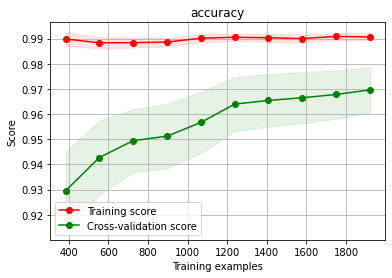

 20%|██        | 1/5 [00:39<02:38, 39.52s/it]

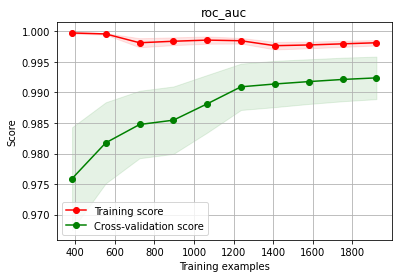

 40%|████      | 2/5 [01:17<01:56, 38.70s/it]

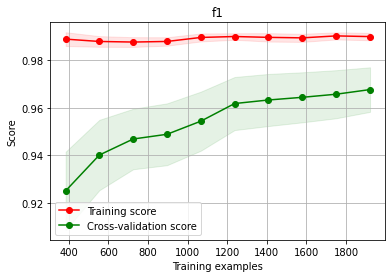

 60%|██████    | 3/5 [01:57<01:18, 39.34s/it]

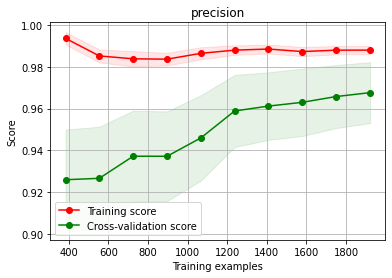

 80%|████████  | 4/5 [02:38<00:40, 40.07s/it]

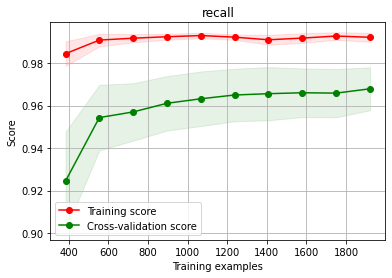

100%|██████████| 5/5 [03:22<00:00, 40.53s/it]


In [4]:
from tqdm import tqdm


for s in tqdm(['accuracy', 'roc_auc', 'f1', 'precision', 'recall']):
    plot = plot_learning_curve(
        pipeline,
        s,
        train,
        train['is_redirect'],
        scoring=s,
        cv=STRONG_CV,
        n_jobs=N_JOBS_CV,
    )
    plot.show()


In [6]:
pipeline.fit(train, train['is_redirect'])

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('query_feats',
                                                 Pipeline(steps=[('query',
                                                                  ColumnSelector(col='query')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  ngram_range=(2,
                                                                                               3)))])),
                                                ('category_name',
                                                 Pipeline(steps=[('category_name',
                                                                  ColumnSelector(col='category_name')),
                                                                 ('tfidf',
                             

In [8]:
pred = pipeline.predict(train)

In [10]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
for s in [roc_auc_score, f1_score, accuracy_score]:
    print(s(pred, train['is_redirect']))

0.9903209426560196
0.9898275099513489
0.9904246461282264


In [12]:
MODEL_PATH = './models/tfidf_baseline'
save_pipeline(pipeline, MODEL_PATH)

In [13]:
MODEL_PATH = './models/tfidf_baseline'
pipeline = load_pipeline(MODEL_PATH)
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('query_feats',
                                                 Pipeline(steps=[('query',
                                                                  ColumnSelector(col='query')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  ngram_range=(2,
                                                                                               3)))])),
                                                ('category_name',
                                                 Pipeline(steps=[('category_name',
                                                                  ColumnSelector(col='category_name')),
                                                                 ('tfidf',
                             

In [14]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
for s in [roc_auc_score, f1_score, accuracy_score]:
    print(s(pred, train['is_redirect']))

0.9903209426560196
0.9898275099513489
0.9904246461282264
